# Learning the Cause of Wildfires
### by Cater Portwood and Christine Miller
#### STA 208 Final Project, Spring 2019

## Introduction
Wildfires are an increasingly common threat to human lives, infrastructure, and wildlife. While occasional wildfires are often a natural part of an ecosystem, the majority of wildfires in the US are human-caused. Determining how fires start is important in suggesting future preventive measures and in bringing those responsible to justice. Currently firefighters, law enforcement, and land managers use a variety of clues to ascertain the cause of a fire. These include burn patterns, location, and local weather. 

Our question is whether machine learning can be used to predict the cause of a fire based on the characteristics of a fire. In particular, can we create a model that will accurately predict whether a fire was caused by arson or not? Characteristics available for prediction include the duration, location, size, land owner, and population density. This project aims to create an additional tool to help prevent wildfires.


## Data
We will be using data on 1.88 million US wildfires from Kaggle: https://www.kaggle.com/rtatman/188-million-us-wildfires

This dataset contains information on the location, timing, duration and final size of the fire, along with identifing information about each fire and the source of the information. A full description of each of the viaraibles included in the dataset can be found at the kaggle link. 
        
In addition to the wildfire dataset we also used information on locations of urban areas from the 2010 census from DATA.gov: https://catalog.data.gov/dataset/tiger-line-shapefile-2017-2010-nation-u-s-2010-census-urban-area-national 

Fire depratments often use information about human presence and influence on the fire's location to suggest the cause of a fire, and we noticed that this information was missing from the data set. The Urban Areas data contains geographic polygons 
that define urban areas with two categories of population density: urbanized areas (UAs) that contain 50,000 or more people and urban clusters (UCs) that contain at least 2,500 people, but fewer than 50,000 people. We used the latitude and longitude coordinates in the fire data set to extract the population desensity for each fire (Code: ExtractUrban.R). 

In [497]:
# load packages
import numpy as np
import pandas as pd
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import plotnine as p9
import seaborn as sns

import sklearn as skl
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import sklearn.preprocessing
import sklearn.mixture
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

## Load Data

In [85]:
# load data
og_fires = pd.read_csv('wildfires.csv', engine='python')

In [86]:
# Subset data to speed computation
percent_of_data = .10
np.random.seed(5)
indices = np.random.randint(0,len(og_fires), int(len(og_fires)*percent_of_data))
fires = og_fires.iloc[indices,:]

In [290]:
# Drop observations with "missing/undefined" cause
# Save for later, perhaps
missing = fires[fires.STAT_CAUSE_DESCR == "Missing/Undefined"]
fires = fires[fires.STAT_CAUSE_DESCR != "Missing/Undefined"]

In [291]:
# make new variable of fire duration with date columns
fires['duration'] = fires.CONT_DOY - fires.DISCOVERY_DOY
fires.loc[fires.duration < 0, "duration"] += 365

fires.duration.describe()

count    91829.000000
mean         1.189886
std          8.442972
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        335.000000
Name: duration, dtype: float64

In [292]:
fires['source_system_fed'] = fires.SOURCE_SYSTEM_TYPE.map(lambda x: int(x != "FED"))
fires.source_system_fed.value_counts()

1    123912
0     47405
Name: source_system_fed, dtype: int64

## Exploratory Data Analysis

In [293]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [294]:
# Look at proportion of missing data
missing_prop = fires.isnull().sum()/fires.shape[0]
missing_prop[missing_prop != 0]

LOCAL_FIRE_REPORT_ID       0.756411
LOCAL_INCIDENT_ID          0.410870
FIRE_CODE                  0.813941
FIRE_NAME                  0.489204
ICS_209_INCIDENT_NUMBER    0.986814
ICS_209_NAME               0.986814
MTBS_ID                    0.993906
MTBS_FIRE_NAME             0.993906
COMPLEX_NAME               0.996807
DISCOVERY_TIME             0.448665
CONT_DATE                  0.463982
CONT_DOY                   0.463982
CONT_TIME                  0.497551
COUNTY                     0.371744
duration                   0.463982
dtype: float64

In [295]:
# Baseline accuracy to beat
print(fires["STAT_CAUSE_DESCR"].value_counts()[0]/len(fires))

0.2498292638792414


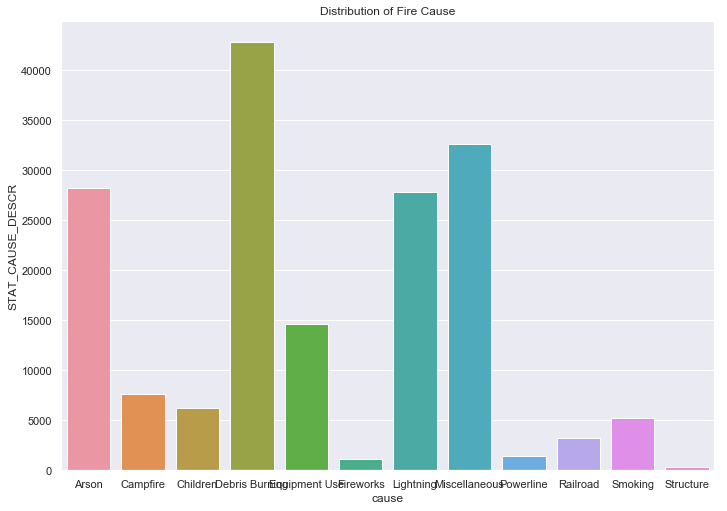

In [400]:
fire_cause_dist = pd.DataFrame(fires["STAT_CAUSE_DESCR"].value_counts()).sort_index()
fire_cause_dist["cause"] = fire_cause_dist.index
_=sns.barplot(data=fire_cause_dist, x="cause", y="STAT_CAUSE_DESCR")
_=plt.title("Distribution of Fire Cause")

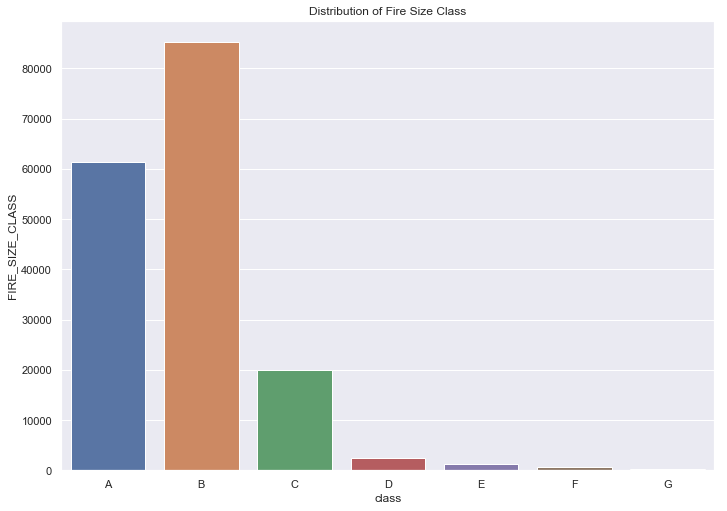

In [346]:
fire_size_dist = pd.DataFrame(fires["FIRE_SIZE_CLASS"].value_counts()).sort_index()
fire_size_dist["class"] = fire_size_dist.index
_=sns.barplot(data=fire_size_dist, x="class", y="FIRE_SIZE_CLASS")
_=plt.title("Distribution of Fire Size Class")

Size goes A (small) to G (large). Nonlinear, see https://www.nwcg.gov/term/glossary/size-class-of-fire for classification.

In [297]:
# Huge outliers - we'll just use FIRE_SIZE_CLASS instead since any scaling will push
# most sizes to essentially zero
fires.FIRE_SIZE.describe()

count    171317.000000
mean         74.994311
std        2576.056951
min           0.000090
25%           0.100000
50%           1.000000
75%           3.000000
max      606945.000000
Name: FIRE_SIZE, dtype: float64

__When do fires happen in the year?__

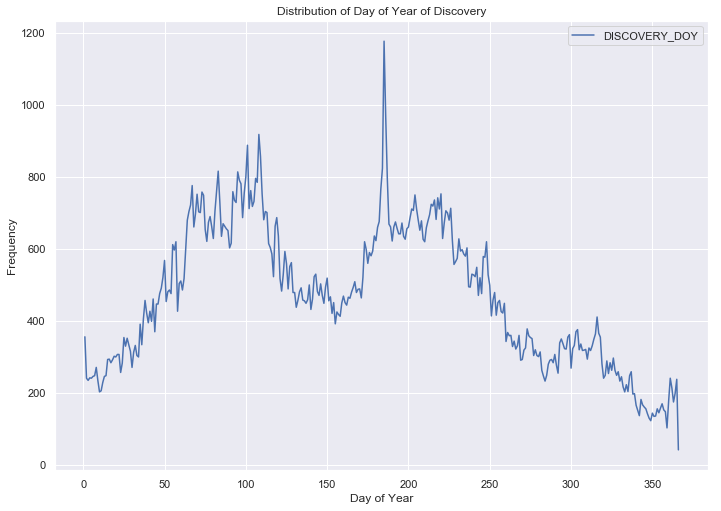

In [490]:
_=pd.DataFrame(fires["DISCOVERY_DOY"].value_counts()).sort_index().plot(kind="line",title="Distribution of Day of Year of Discovery")
_=plt.xlabel("Day of Year")
_=plt.ylabel("Frequency")

The spike between 150-200 is 4th of July. Interestingly, the data is bimodal, with a peak in the spring and a peak in the summer. Why is there a peak in the spring? Now let's see what the distribution by day of year looks like for the top 10 states:

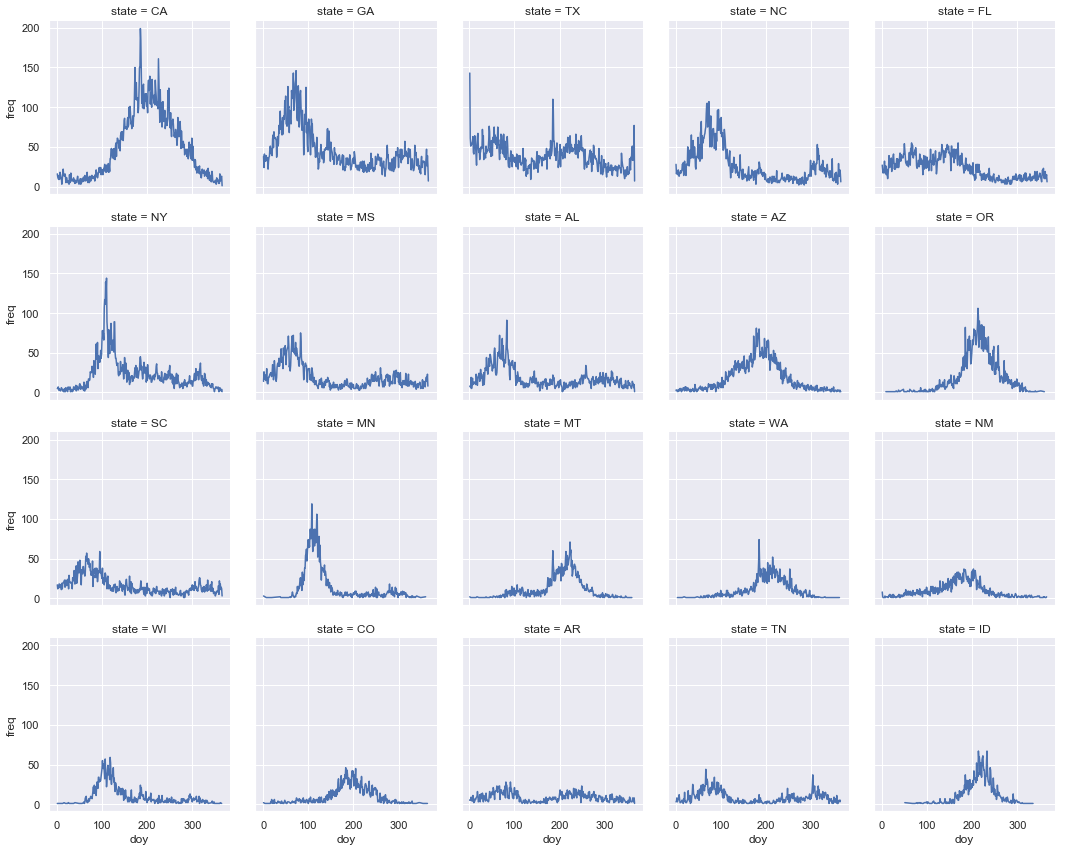

In [347]:
# Make tidy dataset with columns "doy", "freq", and "state"
doy_by_state = pd.DataFrame()
for state in fires.STATE.value_counts().index[0:20]:
    state_doy = fires.loc[fires.STATE==state, "DISCOVERY_DOY"].value_counts().sort_index()
    state_doy = pd.DataFrame(state_doy)
    state_doy["state"] = state
    state_doy.columns = ["freq", "state"]
    doy_by_state = pd.concat([doy_by_state, state_doy])
doy_by_state["doy"] = doy_by_state.index

# Facet plot
p = sns.FacetGrid(doy_by_state, col="state", col_wrap=5)
p = p.map(sns.lineplot, "doy", "freq")

As we can see, the eastern states tend to have most frequent fires in the spring, while the western states tend to have summer fire seasons. Perhaps this is due to summers being significantly drier than winter and spring in the West (while the East tends to have more consistent precipitation year-round), and a higher proportion of fires being lightning-caused in the more sparsely populated West (see map below).

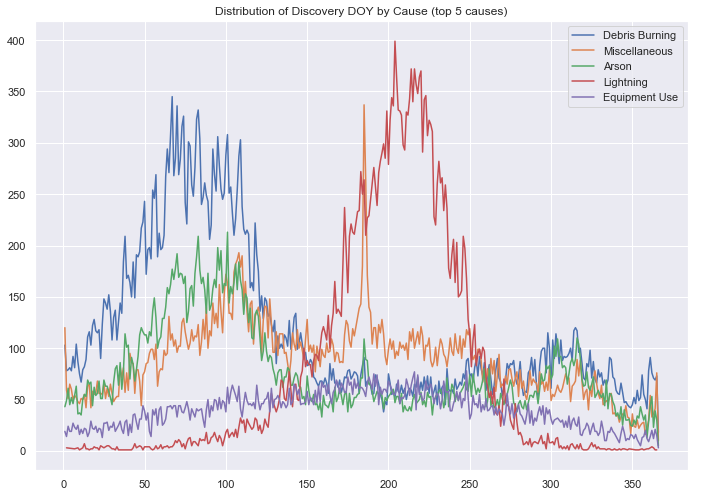

In [300]:
def plot_freq_by_cause(cause):
    doy_df = fires.loc[fires["STAT_CAUSE_DESCR"] == cause, "DISCOVERY_DOY"]
    _=plt.plot(doy_df.value_counts().sort_index(), label=cause)
    _=plt.legend()
    
for cause in fires["STAT_CAUSE_DESCR"].value_counts().index[0:5]:
    _=plot_freq_by_cause(cause)
    
_=plt.title("Distribution of Discovery DOY by Cause (top 5 causes)")

The message from this plot is clear: human-caused fires peak in the spring, while lightning-caused fires peak in the summer. This bodes well for using discovery day of year to distinguish wildfire cause. Below are the distributions by day of year of the rest of the wildfire causes.

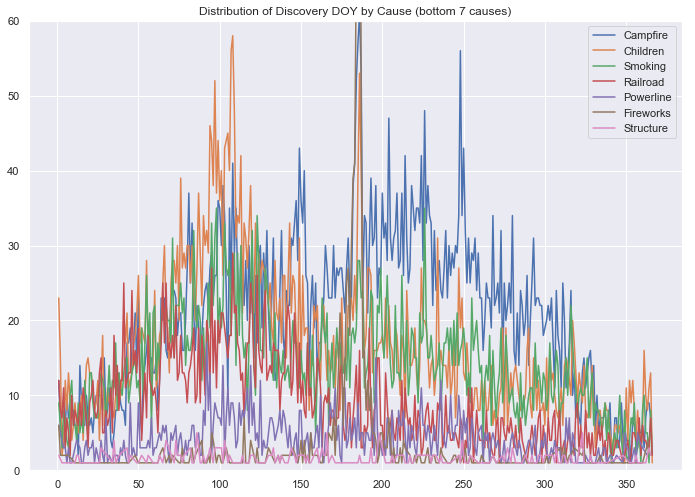

In [301]:
for cause in fires["STAT_CAUSE_DESCR"].value_counts().index[5:]:
    _=plot_freq_by_cause(cause)
    
_=plt.ylim([0,60])
_=plt.title("Distribution of Discovery DOY by Cause (bottom 7 causes)")

__Where do fires occur?__

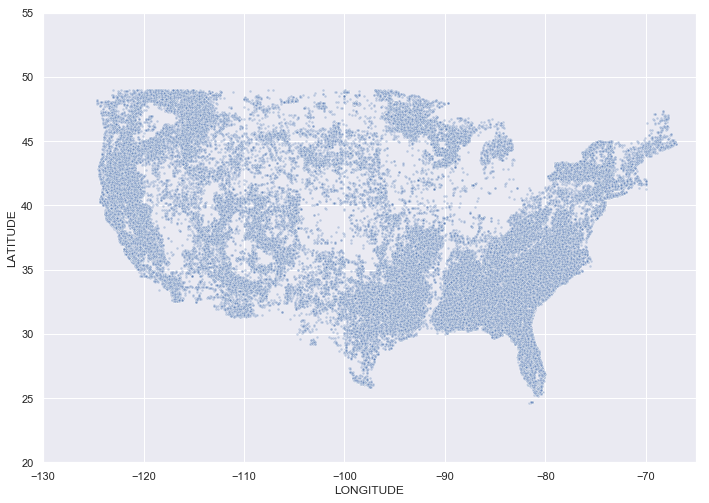

In [476]:
_=sns.scatterplot(data=fire_top_causes, 
                  y="LATITUDE", x="LONGITUDE",color="urbantype"
                  s=8, alpha=.3)
_=plt.xlim((-130,-65))
_=plt.ylim((20,55))

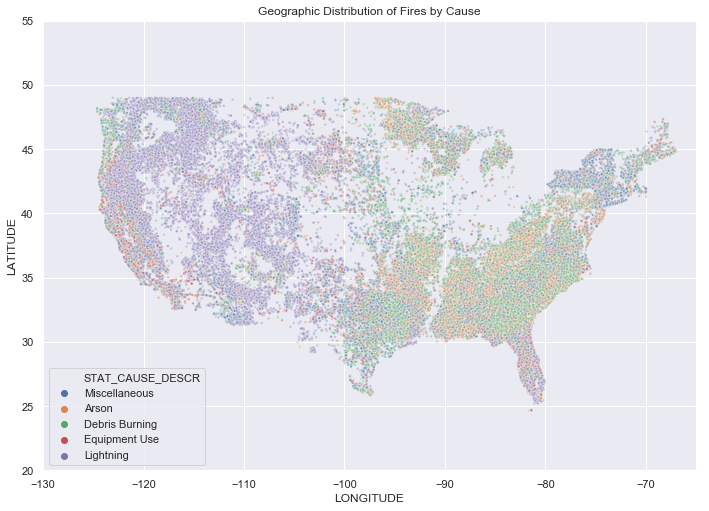

In [477]:
top_five = fires.STAT_CAUSE_DESCR.isin(fires["STAT_CAUSE_DESCR"].value_counts().index[0:5])
fire_top_causes = fires[top_five]

_=sns.scatterplot(data=fire_top_causes, 
                  y="LATITUDE", x="LONGITUDE", hue="STAT_CAUSE_DESCR",
                  s=8, alpha=.3)
_=plt.xlim((-130,-65))
_=plt.ylim((20,55))
_=plt.title("Geographic Distribution of Fires by Cause")

We can see that the intensive agriculture of the Mississippi Valley, Midwest, and Plains is correlated with a lack of fires. Lightning clearly dominates as the cause of fire in the sparsely populated regions of the West. Some lines appear in Southern California/Arizona which may correspond to Interstates 10, 40, and 15. The curved band of forests across Arizona is visible, as are the forests of the Upper Midwest.

The appearance of New York's borders with Pennsylvania and Vermont suggest a difference in reporting. New York fires also appear to be disproportionately "miscellaneous" in cause. Otherwise, political boundaries are not clear in this map, a good sign for the quality of the data. 

## Prepare Data for Modeling

In [341]:
# trim to the predictor variables of interest
predictors = fires[['FIRE_YEAR','DISCOVERY_DOY',
       'DISCOVERY_TIME', 'FIRE_SIZE', 'LATITUDE',
       'LONGITUDE', 'source_system_fed',
        'urbantype', 'duration']]
target = fires['STAT_CAUSE_DESCR']

## encode all categorical variables including the fire causes
# make labelEncoder for fire causes
cause_encode = skl.preprocessing.LabelEncoder()
cause_encode.fit(list(target.values)) 
target = cause_encode.transform(list(target.values))

# Encode urbantype
urban_encoder = lambda x: {"R":0, "C":1, "U":2}[x]
predictors['urbantype'] = predictors['urbantype'].map(urban_encoder)

/Users/carterportwood/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [342]:
# Id the numberic columns before label encoding so we can scale them later
num_cols = predictors.select_dtypes(include='number').columns
num_cols

Index(['FIRE_YEAR', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'FIRE_SIZE', 'LATITUDE',
       'LONGITUDE', 'source_system_fed', 'urbantype', 'duration'],
      dtype='object')

In [343]:
# training/test split (hold out 1/5 of the data for testing)
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(predictors, target, test_size = 0.2)

In [505]:
def scale_impute(x_data, num_cols):
    # scale numberic columns of x data
    mm_scaler = skl.preprocessing.MinMaxScaler(feature_range=(0, 1))
    qt_scaler = skl.preprocessing.QuantileTransformer(output_distribution="normal")
    
    # Suppress setting with copy warning
    pd.options.mode.chained_assignment = None
    
    num_cols = num_cols.drop("FIRE_SIZE")
    x_scaled = mm_scaler.fit_transform(x_data[num_cols])
    x_data[num_cols] = x_scaled
    
    # Use quantile transform on fire size because of extreme outliers
    fire_size_scaled = qt.fit_transform(np.array(fires["FIRE_SIZE"]).reshape(-1,1))
    fire_size_scaled = pd.Series(fire_size_scaled[:,0])
    x_data["FIRE_SIZE"] = fire_size_scaled

    
    # make new columns indicating what will be imputed
    cols_with_missing = [col for col in x_data.columns 
                                 if x_data[col].isnull().any()]
    
    for col in cols_with_missing:
        x_data[col + '_was_missing'] = x_data[col].isnull()

    col_names = x_data.columns
    
    
    # Imputation
    my_imputer = SimpleImputer()
    x_data = pd.DataFrame(my_imputer.fit_transform(x_data))
    x_data.columns = col_names
    
    x_data = x_data.drop("duration_was_missing", axis=1)
    
    return(x_data)

In [506]:
X_train_imp = scale_impute(X_train, num_cols)
X_train_imp.head()

X_test_imp = scale_impute(X_test, num_cols)
X_test_imp.head()

,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,FIRE_SIZE,LATITUDE,LONGITUDE,source_system_fed,urbantype,duration,DISCOVERY_TIME_was_missing,FIRE_SIZE_was_missing
0,0.869565,0.605479,0.613254,-0.009576,0.197963,0.675594,1.0,0.0,0.003785,1.0,1.0
1,0.217391,0.545205,0.613254,-0.009576,0.337512,0.869853,1.0,0.0,0.003785,1.0,1.0
2,0.217391,0.638356,0.860534,-0.009576,0.510050,0.571042,0.0,0.0,0.000000,0.0,1.0
3,0.478261,0.073973,0.613254,-0.009576,0.256572,0.760890,1.0,0.0,0.003785,1.0,1.0
4,0.565217,0.273973,0.563798,-0.168912,0.401461,0.821294,0.0,0.0,0.000000,0.0,0.0


## Predicting the causes of wildfires

In [384]:
# This function is taken from with slight modifications: https://bit.ly/2DCTGd5 
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### All-Causes Random Forest

In [376]:
max_features = ['auto', 'sqrt']
max_depth = [3, 5, None]
min_samples_split = [2, 10]


multiclass_rf_grid = {
    'n_estimators': [20],
    'min_samples_split': min_samples_split,
    'max_features': max_features}

multiclass_rf_cv = skl.model_selection.GridSearchCV(RandomForestClassifier(), multiclass_rf_grid,
                                               cv=3, 
                                               scoring = "accuracy")

multiclass_rf_cv.fit(X_train_imp, y_train)

multiclass_rf_pred = multiclass_rf_cv.predict(X_test_imp)
skl.metrics.accuracy_score(multiclass_rf_pred, y_test)

0.4890555685267336

In [386]:
multiclass_rf_cv.best_params_

{'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 20}

In [494]:
y_test_labels = cause_encode.inverse_transform(y_test)
multiclass_rf_pred_labels = cause_encode.inverse_transform(multiclass_rf_pred)
causes = cause_encode.inverse_transform(list(range(0,12)))

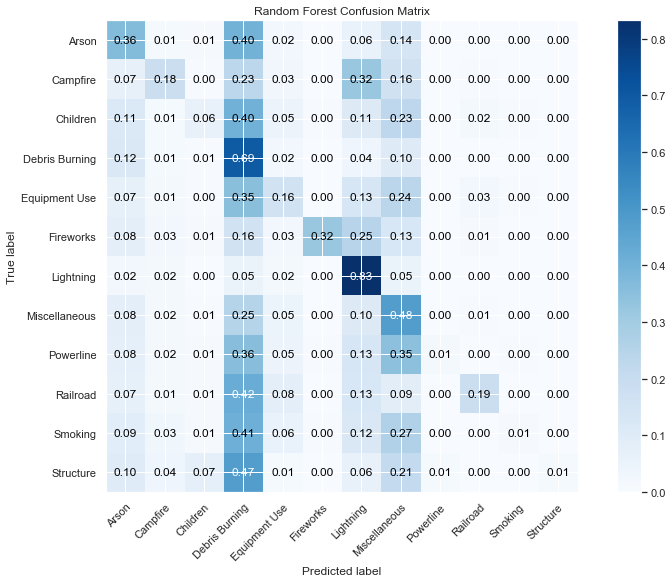

In [502]:
plot_confusion_matrix(y_test_labels, multiclass_rf_pred_labels, causes, normalize=True)
_=plt.title("Random Forest Confusion Matrix")

### All-Causes KNN

In [488]:
multiclass_knn_grid = {
    "p":[1,2],
    "n_neighbors":[3,5]
}

multiclass_knn_cv = skl.model_selection.GridSearchCV(KNeighborsClassifier(), multiclass_knn_grid,
                                               cv=3, 
                                               scoring = "accuracy")

multiclass_knn_cv.fit(X_train_imp, y_train)

multiclass_knn_pred = knn_cv.predict(X_test_imp)
skl.metrics.accuracy_score(multiclass_knn_pred, y_test)

0.454412794770021

In [491]:
multiclass_knn_cv.best_params_

{'n_neighbors': 5, 'p': 1}

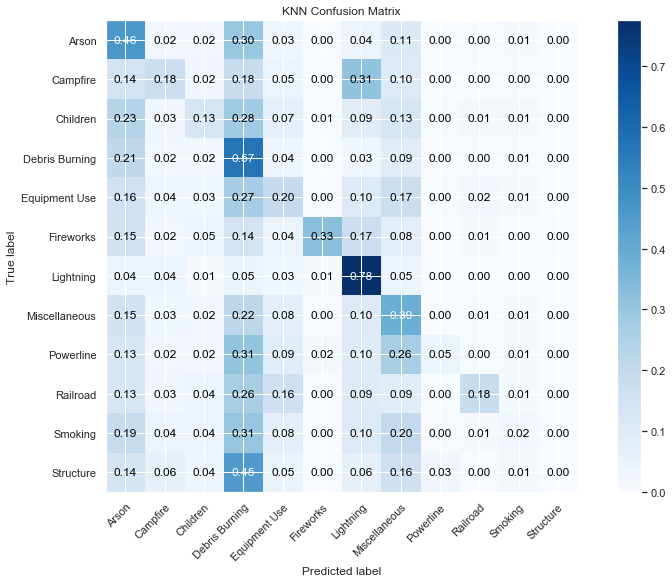

In [503]:
multiclass_knn_pred_labels = cause_encode.inverse_transform(knn_pred)
plot_confusion_matrix(y_test_labels, multiclass_knn_pred_labels, causes, normalize=True)
_=plt.title("KNN Confusion Matrix")

### All-Causes Gradient Boosting Classifier

In [498]:
multiclass_gb = GradientBoostingClassifier()

multiclass_gb.fit(X_train_imp, y_train)
multiclass_gb_pred = multiclass_gb.predict(X_test_imp)

skl.metrics.accuracy_score(multiclass_gb_pred, y_test)

0.4650070044361429

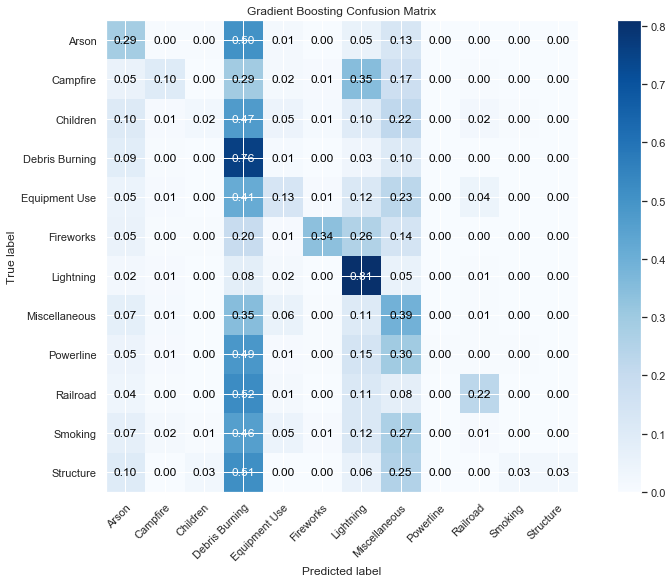

In [501]:
multiclass_gb_pred_labels = cause_encode.inverse_transform(multiclass_gb_pred)
plot_confusion_matrix(y_test_labels, multiclass_gb_pred_labels, causes, normalize=True)
_=plt.title("Gradient Boosting Confusion Matrix")

### Multiclass Classification Discussion

The random forest classifier performed best with an accuracy of 48.9%. Th un-tuned gradient boosting model had an accuracy of 46.5%, and the KNN model had an accuracy of 45.4%. 

Tuning and the amount of data used were limited by computation time and power (the above is only using 10% of the data!). More exhaustive parameter cross-validation searches would've been possible with greater computation power. 

The models did not fit the data very well, as we can see with the confusion matrices above. Classification with 12 classes is a difficult task, and the lower-frequency causes likely serve only to degrade the performance of the model. The most common causes clearly dominate the predictions.

Future directions could include fitting a human-caused vs. non-human-caused model, in addition to the arson vs. not-arson predictions below.

## Arson vs Not-Arson

### Benchmarking 